In [438]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import sys
import seaborn as sns
sys.path.append('../creme/')
import creme
import utils
import shutil
import pickle
import glob
import pandas as pd
import numpy as np
import itertools, os
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [406]:
cell_lines = [4824, 5110, 5111]
cell_line_names = ['PC-3', 'GM12878', 'K562']
bin_index = [447, 448]
model_name = 'enformer'
pdf_dir = utils.make_dir('pdf_dir')

threshold_enh, threshold_neu, threshold_sil = 0.95, 0.05, -0.3

In [449]:
res = []
for i, c in enumerate(cell_lines):
    selected_tss_path = glob.glob(f'../results/gencode_tss_predictions/{model_name}/*{c}*_selected_tss.csv')[0]
    cell_name = selected_tss_path.split('_')[-3]
    delta_means = []
    delta_stds = []
    paths = []
    print(cell_name)
    selected_tss = pd.read_csv(selected_tss_path)
    for _, row in selected_tss.iterrows():
        
        r = f'../results/context_dependence_test/{model_name}/{utils.get_summary(row)}.pickle'
        with open(r, 'rb') as handle:
            context_res = pickle.load(handle)
        delta = creme.context_effect_on_tss(context_res['wt'][:,i], context_res['mut'][:,i], bin_index)
        delta_means.append(delta.mean())
        delta_stds.append(delta.std())
        paths.append(r)
        
    df = pd.DataFrame([delta_means, delta_stds, paths]).T
    df.columns = ['delta mean', 'delta std', 'path']
    df = df[df['delta std'] < np.quantile(df['delta std'], 0.99)]
    df['context'] = [v for v in pd.cut(df['delta mean'], 
                                       [df['delta mean'].min()-1, threshold_sil, -threshold_neu, threshold_neu, threshold_enh, df['delta mean'].max()+1], 
                           labels=['silencing', 'other1', 'neutral', 'other', 'enhancing']).values]
    df['cell line'] = cell_name
    res.append(df)

res = pd.concat(res)
    

PC-3
GM12878
K562


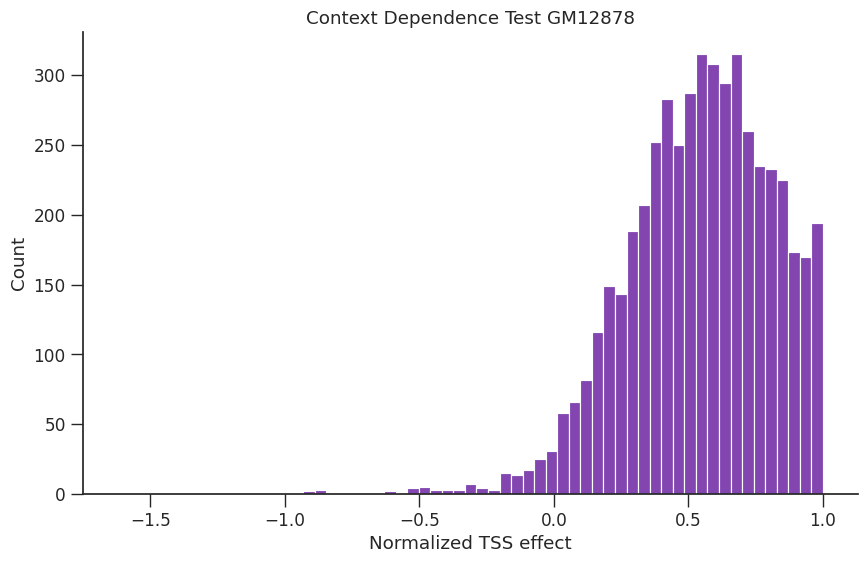

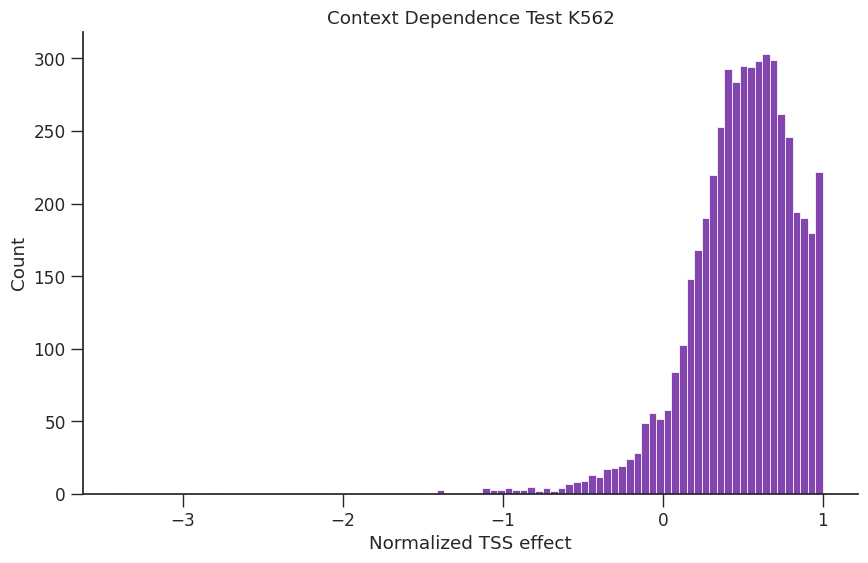

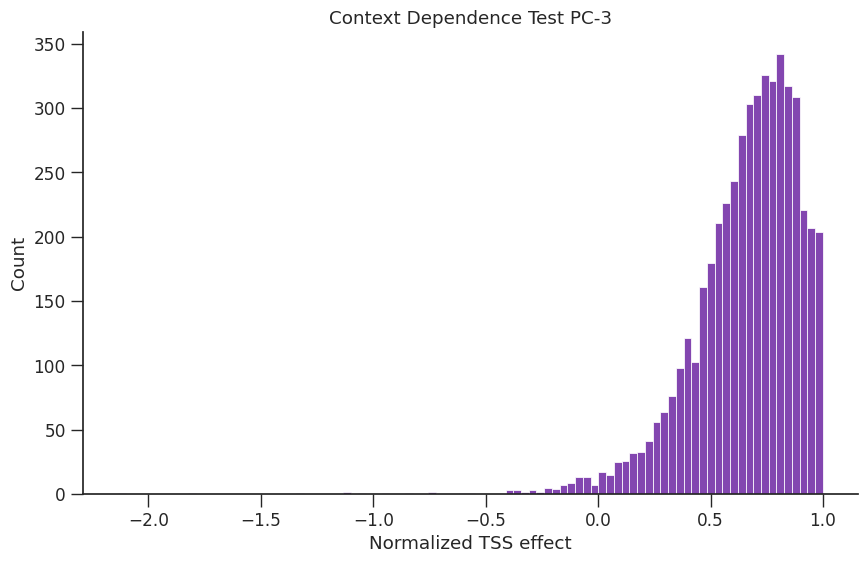

In [450]:
sns.set(font_scale = 1.1)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 9
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
for k, df in res.groupby('cell line'):
    
    fig = plt.figure(figsize=[10, 6])

    

    ax = sns.histplot(x=df['delta mean'], color='#5A0896')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.xlabel('Normalized TSS effect') # (WT - M) / WT
    # plt.xlim([-2,1.1])
    # plt.xticks([-2, -1, 0, 1])
    # plt.yticks([100, 200, 300])
    plt.title(f'Context Dependence Test {k}')
    fig.savefig(f'{pdf_dir}/{model_name}_{k}_TSS_context_effect_hist.pdf', format='pdf', dpi=300, bbox_inches='tight')


['enhancing (N=217)', 'neutral (N=98)', 'silencing (N=36)']
['enhancing (N=230)', 'neutral (N=123)', 'silencing (N=128)']
['enhancing (N=290)', 'neutral (N=32)', 'silencing (N=20)']


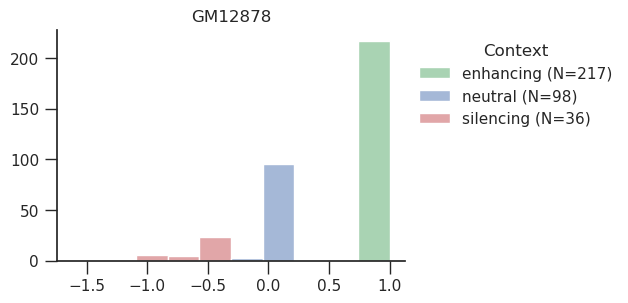

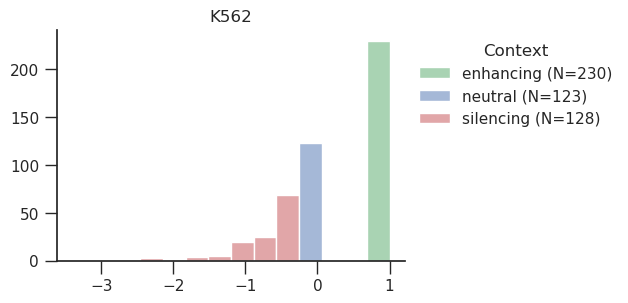

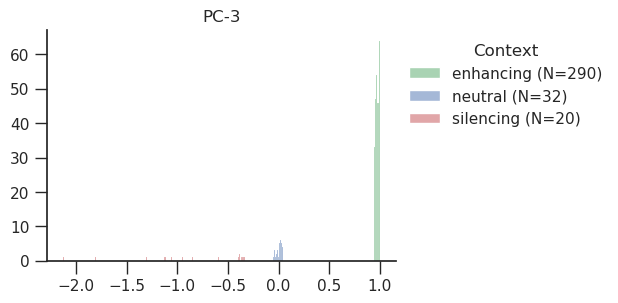

In [455]:
for k, df in res.groupby('cell line'):
    
    
    fig = plt.figure(figsize=[4.5, 3])
    sns.set(font_scale = 1.)
    sns.set_style(style='white')
    plt.rcParams['xtick.major.size'] = 9
    plt.rcParams['xtick.major.width'] = 1
    
    plt.rcParams['ytick.major.size'] = 9
    plt.rcParams['ytick.major.width'] = 1
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left'] = True
    context_df = df[(df['context']!='other') & (df['context']!='other1')]
    context_df = context_df.sort_values('context')
    ax = sns.histplot(data=context_df, 
                      x='delta mean', hue='context', 
                      hue_order=['enhancing', 'neutral', 'silencing'],
                      palette=['g', 'b', 'r'])
    
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # plt.legend(frameon=False);
    legend = ax.get_legend()
    handles = legend.legend_handles
    legend.remove()
    labels = [f"{c} (N={s})" for _, (c, s) in context_df.groupby('context').count().reset_index().iloc[:,:2].iterrows() 
              if 'other' not in c]
    print(labels)
    ax.legend(handles, labels,
              title='Context', frameon=False, bbox_to_anchor=[1,1])
    
    plt.ylabel('')
    plt.xlabel('')
    
    plt.title(k)
    # plt.ylim(0,100)
    # plt.xlim([-2,1.1])
    # plt.yticks([0,50,100])
    fig.savefig(f'{pdf_dir}/{model_name}_{k}_TSS_context_effect_inset.pdf', format='pdf', dpi=300, bbox_inches='tight')
    context_df.to_csv(f'../results/context_dependence_test/{model_name}/{k}_context.csv')


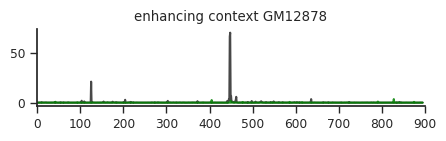

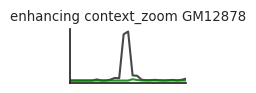

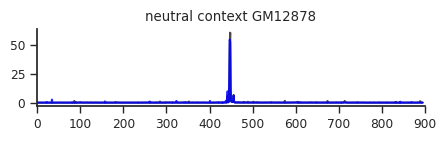

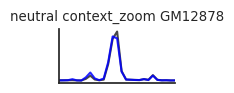

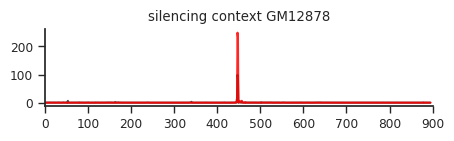

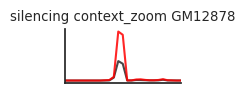

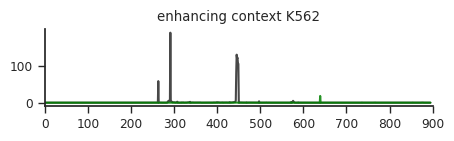

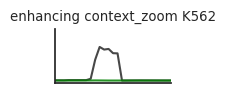

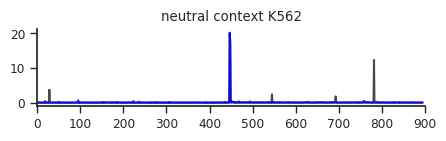

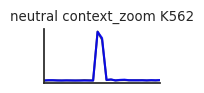

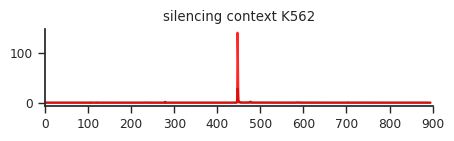

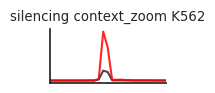

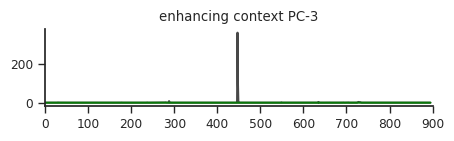

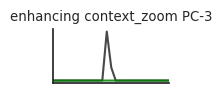

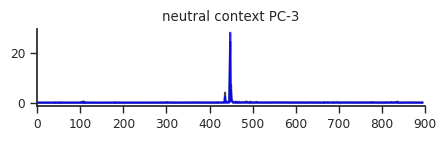

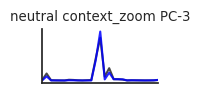

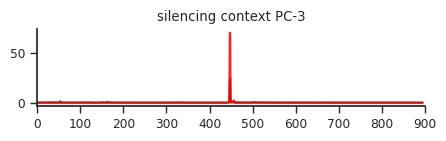

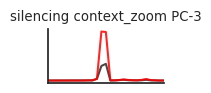

In [453]:
for k, df in res.groupby('cell line'):
    
    cell_pred_index = cell_line_names.index(k)

    # select most illustrative cases
    
    for name, color, selected_point in zip(['enhancing context', 'neutral context', 'silencing context'],
                                    ['green', 'blue', 'red'],
                                    [df[df['context']=='enhancing'].sort_values('delta mean')['path'].values[-1],
                                     df[df['context']=='neutral']['path'].values[0],
                                     df[df['context']=='silencing'].sort_values('delta mean')['path'].values[0]
                                     ]):
        with open(selected_point, 'rb') as handle:
            context_res = pickle.load(handle)
        wt = context_res['wt'][:, cell_pred_index]
        mut = context_res['mut'][:, cell_pred_index]
        for zoom in [None, [425, 475]]:
            if zoom:
                fig = plt.figure(figsize=[1.5, .7])
                name = name + '_zoom'
            else:
                fig = plt.figure(figsize=[5, 1])
                
            sns.set(font_scale = .8)
        
            sns.set_style(style='white')
            plt.rcParams['xtick.major.size'] = 5
            plt.rcParams['xtick.major.width'] = 1
        
            plt.rcParams['ytick.major.size'] = 5
            plt.rcParams['ytick.major.width'] = 1
            plt.rcParams['xtick.bottom'] = True
            plt.rcParams['ytick.left'] = True
        
            plt.plot(wt, 'k', alpha=0.8)
            plt.plot(mut, color=color, alpha=0.85)
            plt.xlim(0, 900)
            
            if zoom is None:
                if k == 'strong':
                    plt.ylabel('TSS activity')
                if k == 'repressing CRE':
                    plt.xlabel('Binned positions (128 nt)')
                    
            if zoom:
                sns.set(font_scale = .8)
                plt.xticks([])
                plt.yticks([])
                plt.xlim(435, 461)
            plt.gca().spines['top'].set_visible(False)
            plt.gca().spines['right'].set_visible(False)
            plt.title(f'{name} {k}')
            plt.show()
            # fig.savefig(f'{pdf_dir}/{model_name}_{k}_{name}.pdf', format='pdf', dpi=300, bbox_inches='tight')
    #     break
    # break

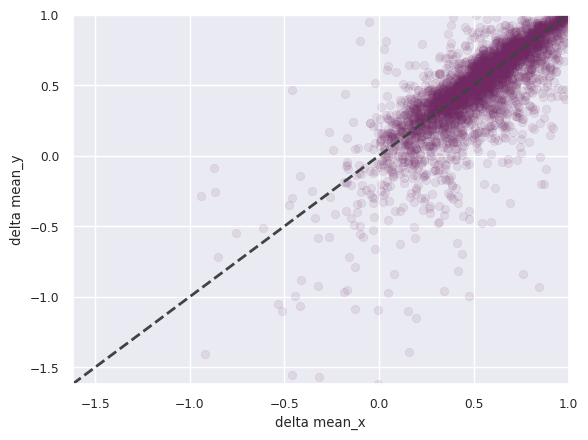

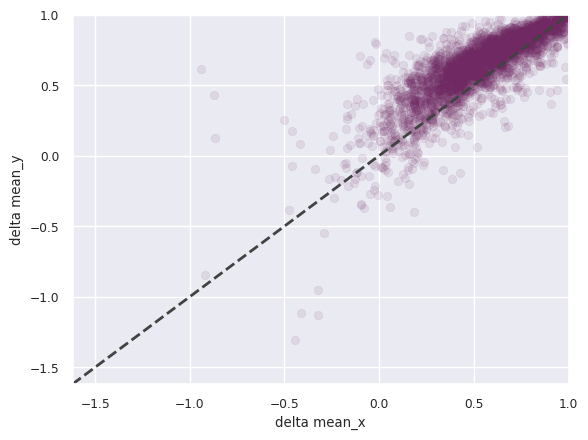

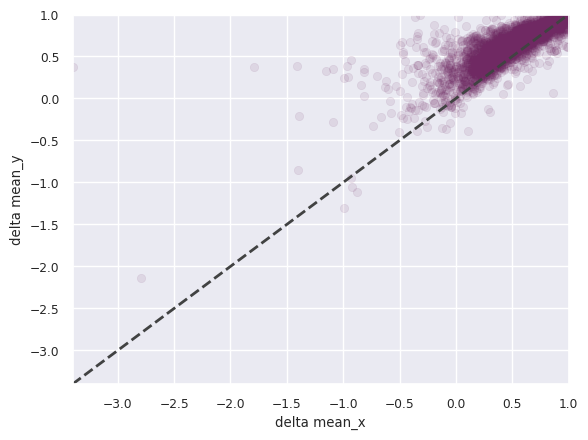

In [454]:
for df1, df2 in list(itertools.combinations([df for _, df  in res.groupby('cell line')], 2)):
    diff_comp = df1.merge(df2, on='path')
    sns.scatterplot(data=diff_comp, x='delta mean_x', y='delta mean_y', edgecolors=None, color='#702963', alpha=0.1)
    min_point = np.array(diff_comp['delta mean_x'], diff_comp['delta mean_y']).min()
    # add y=x line
    plt.plot([min_point,1],[min_point,1], lw=2, color='#414242', linestyle='dashed')
    # plt.xlabel(f'{c1} normalized TSS effect')
    # plt.ylabel(f'{c2} normalized TSS effect')
    plt.xlim(min_point,1)
    plt.ylim(min_point,1)
    plt.show()